# Multimodal Housing Classification Pipeline

This notebook implements a multimodal deep learning pipeline to classify housing types based on both image data and tabular features.

Currently it uses an example Hybrid-model, this part will be exchanged for other models.

## Table of Contents

- [Section 1: Setup and Environment](#section-1-setup-and-environment)  
- [Section 2: Data Ingestion](#section-2-data-ingestion)  
- [Section 3: Preprocessing and Splitting](#section-3-preprocessing-and-splitting)  
- [Section 4: Dataset and DataLoader](#section-4-dataset-and-dataloader)  
- [Section 5: Multimodal Model Definition](#section-5-multimodal-model-definition)  
- [Section 6: Training & Validation Functions](#section-6-training--validation-functions)  
- [Section 7: Evaluation & Model Utilities](#section-7-evaluation--model-utilities)  
- [Section 8: Pipeline Execution](#section-8-pipeline-execution)

---

## Section 1: Setup and Environment

- Load necessary libraries for data handling, preprocessing, modeling, and visualization.
- Configure device (GPU/CPU).
- Load environment variables for paths (ensure `.env` file contains `FILE_PATH`).
- Define image directory and CSV data path.

Make sure you have the `.env` file properly configured with the base file path to your dataset and images.


In [20]:
# --- Section 1: Setup ---
import os
import pandas as pd
import numpy as np
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score, 
    log_loss, 
    classification_report, 
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Check for torch.py shadowing
import glob
print("Files named torch.py in current directory:", glob.glob('./torch.py'))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment and Path Configuration
load_dotenv()
BASE_DIR = os.getenv('FILE_PATH')
if not BASE_DIR:
    raise ValueError("FILE_PATH environment variable not set. Please create a .env file and set it.")

DATA_PATH = os.path.join(BASE_DIR, 'Full_preprocessed_detailed_house.csv')
print(f"Base Directory: {BASE_DIR}")
print(f"Data CSV Path: {DATA_PATH}")


Files named torch.py in current directory: []
Using device: cuda
Base Directory: ../../../Samsung_USB/
Data CSV Path: ../../../Samsung_USB/Full_preprocessed_detailed_house.csv


In [21]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

True
1
NVIDIA GeForce RTX 3050 Laptop GPU


## Section 2: Data Ingestion

- Load the dataset CSV file into a DataFrame.
- Print confirmation and dataset shape.


In [22]:
# --- Section 2: Data Ingestion ---
df = pd.read_csv(DATA_PATH)
print("Successfully loaded data. Shape:", df.shape)

Successfully loaded data. Shape: (6595, 24)


## Section 3: Preprocessing and Splitting

- Stratified splitting of dataset into train (60%), validation (20%), and test (20%) sets based on the target label (`woningtype`).
- Scale numeric features using training set statistics.
- One-hot encode categorical features using training set statistics.
- Clean and convert features to numeric types and handle missing values.
- Create full image paths and encode target labels with `LabelEncoder`.
- Define final tabular features for the model.


In [23]:
# --- Section 3: Preprocessing and Splitting ---

def preprocess_tabular_data(train_df, val_df, test_df):
    """Scales numeric columns and one-hot encodes categorical columns."""
    numeric_cols = ['opp_pand', 'build_year', 'huisnr', 'procent_ingenomen', 'perimeter']
    categorical_cols = ['build_type']
    
    # Scale numeric columns based on the training set
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    print("Numeric features scaled.")

    for col in ['centroid_x', 'centroid_y']:
        min_val = train_df[col].min()
        max_val = train_df[col].max()
        for df in [train_df, val_df, test_df]:
            df[col] = (df[col] - min_val) / (max_val - min_val + 1e-8)

    # One-hot encode categorical columns based on the training set
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(train_df[categorical_cols])
    
    cat_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    def encode_and_merge(df, encoder):
        encoded_data = encoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=cat_encoded_cols, index=df.index)
        return pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    train_df = encode_and_merge(train_df, encoder)
    val_df = encode_and_merge(val_df, encoder)
    test_df = encode_and_merge(test_df, encoder)
    print("Categorical features one-hot encoded.")
    
    return train_df, val_df, test_df, numeric_cols, cat_encoded_cols


def clean_and_convert_features(df, feature_list):
    """Ensures all specified feature columns are numeric, filling NaNs."""
    cleaned_df = df.copy()
    for feature in feature_list:
        if feature in cleaned_df.columns:
            # Convert to numeric, coercing errors to NaN
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            # Fill any resulting NaNs with 0 (or a more suitable value like the mean)
            if cleaned_df[feature].isnull().sum() > 0:
                cleaned_df[feature] = cleaned_df[feature].fillna(0)
            # Ensure final type is float32 for PyTorch
            cleaned_df[feature] = cleaned_df[feature].astype('float32')
    return cleaned_df

def prepare_final_data(df, base_path):
    """Adds the full image path and encodes the 'woningtype' label."""
    # Build full image path
    df['img_path'] = df['frontview_url'].apply(lambda x: os.path.join(base_path, x))
    return df

# 1. Split the original dataframe
print("Splitting data into train (60%), validation (20%), and test (20%)...")
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['woningtype'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['woningtype'])

# 2. Preprocess tabular data (scaling and encoding)
train_df, val_df, test_df, numeric_cols, cat_encoded_cols = preprocess_tabular_data(train_df, val_df, test_df)

# 3. Define the full list of features for the model
tabular_features = numeric_cols + cat_encoded_cols
print(f"Total tabular features ({len(tabular_features)}): {tabular_features}")

# 4. Clean the dataframes to ensure all feature columns are numeric
print("Cleaning and converting features to numeric types...")
train_df = clean_and_convert_features(train_df, tabular_features)
val_df = clean_and_convert_features(val_df, tabular_features)
test_df = clean_and_convert_features(test_df, tabular_features)

# 5. Create image paths and encode labels
print("Preparing final data (image paths and labels)...")
train_df = prepare_final_data(train_df, BASE_DIR)
val_df = prepare_final_data(val_df, BASE_DIR)
test_df = prepare_final_data(test_df, BASE_DIR)

# Fit LabelEncoder on the full training 'woningtype' to create integer labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['woningtype'])
# Use the same encoder for validation and test sets
val_df['label'] = label_encoder.transform(val_df['woningtype'])
test_df['label'] = label_encoder.transform(test_df['woningtype'])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

Splitting data into train (60%), validation (20%), and test (20%)...
Numeric features scaled.
Categorical features one-hot encoded.
Total tabular features (10): ['opp_pand', 'build_year', 'huisnr', 'procent_ingenomen', 'perimeter', 'build_type_Appartement', 'build_type_Hoekwoning', 'build_type_Tussen of geschakelde woning', 'build_type_Tweeonder1kap', 'build_type_Vrijstaande woning']
Cleaning and converting features to numeric types...
Preparing final data (image paths and labels)...
Train size: 3957 | Val size: 1319 | Test size: 1319
Number of classes: 10


## Section 4: Dataset and DataLoader

- Custom PyTorch `Dataset` class loads images and tabular features on-the-fly.
- Applies data augmentations only on training data (random horizontal flips and rotations) (SUBJECT TO CHANGE).
- Uses ImageNet normalization to match pretrained model input expectations.
- DataLoaders created with batch size of 32 and multi-threading support (adjust `NUM_WORKERS` accordingly).

**Notes:**
- You can adjust batch size and transforms to fit your hardware and data augmentation preferences.


In [24]:
# --- Section 4: Dataset and DataLoader ---

class HousingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.counter = 0

        self._remove_missing()

    def __len__(self):
        return len(self.df)

    def _remove_missing(self):
        to_drop = []
        for idx, row in self.df.iterrows():
            img_path = row.get('img_path', row.get('frontview_url', None))
            if img_path is None:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row: missing image path')
                continue
            try:
                # Only check if file exists, don't open image (faster, avoids PIL errors on valid images)
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File not found: {img_path}")
            except Exception as e:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row due to image load error: {e}')

        # Drop all invalid rows at once
        self.df = self.df.drop(index=to_drop).reset_index(drop=True)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row.get('img_path', row.get('frontview_url', None))
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            # Extract tabular features as a float32 tensor
            tabular_data = torch.tensor(row[tabular_features].values.astype(np.float32), dtype=torch.float32)
            label = torch.tensor(row['label'], dtype=torch.long)
            return img, tabular_data, label
        except Exception as e:
            # print(f"Error loading data at index {idx} (path: {img_path}). Skipping. Error: {e}")
            return self.__getitem__((idx + 1) % len(self))

# ImageNet normalization values, commonly used for pretrained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Add some augmentation (OPTIONEEL)
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# Initialize datasets
train_dataset = HousingDataset(train_df, transform=train_transforms)
val_dataset = HousingDataset(val_df, transform=val_transforms)
test_dataset = HousingDataset(test_df, transform=val_transforms)

# Create DataLoaders
BATCH_SIZE = 32 # Adjusted for common GPU memory sizes, can be tuned
# Set num_workers=0 on Windows or for debugging, can be > 0 on Linux for performance
NUM_WORKERS = 0 if os.name == 'nt' else 2 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Datasets and DataLoaders created successfully.")


Dropped 1th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000051031-funda.jpg


Dropped 2th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0983200000089957-funda-in-business.jpg
Dropped 3th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0928200000017245-funda.jpg
Dropped 4th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/02/0269200000005631-funda-in-business.jpg
Dropped 5th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0907200000015381-funda.jpg
Dropped 6th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0983200000019253-funda.jpg
Dropped 7th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0995200000807820-funda.jpg
Dropped 8th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0935200000058871-funda.jpg
Dropped 9th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0984200000015956-funda.jpg
Dropped 10th row

## Section 5: Multimodal Model Definition

### ZET HIER JE MODEL

### Currently: 
- CNN backbone: ResNet18 pretrained on ImageNet, outputs 512-dim image features.
- Tabular MLP: Two-layer fully connected network with batch normalization and dropout.
- Fusion layer concatenates image and tabular embeddings before final classification head.

**Parameters to tune:**
- `tabular_input_dim`: Number of tabular features.
- Dropout rates and hidden layer sizes can be modified for regularization and capacity.


In [25]:
# --- Section 5: Model Definition ---

class TabularModel(nn.Module):
    """
    MLP for tabular features matching `tabular_emb_dim`.
    """
    def __init__(self, input_dim, emb_dim=128, hidden_dim=256, dropout=0.3):
        super(TabularModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, emb_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_tab):
        return self.mlp(x_tab)

class RandomForestTabular:
    """
    Wrapper for sklearn RandomForestClassifier for tabular fusion.
    """
    def __init__(self, input_dim, num_classes, **kwargs):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, **kwargs)
        self.num_classes = num_classes
        self.is_fitted = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted = True

    def predict_proba(self, X):
        if not self.is_fitted:
            raise RuntimeError("RandomForestTabular must be fitted before calling predict_proba.")
        return self.model.predict_proba(X)

class XGBoostTabular:
    """
    Wrapper for XGBoost XGBClassifier for tabular fusion.
    """
    def __init__(self, input_dim, num_classes, **kwargs):
        self.model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss', **kwargs)
        self.num_classes = num_classes
        self.is_fitted = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted = True

    def predict_proba(self, X):
        if not self.is_fitted:
            raise RuntimeError("XGBoostTabular must be fitted before calling predict_proba.")
        return self.model.predict_proba(X)
    
class MaskModel(nn.Module):
    """
    CNN for mask features (bird's eye view of the house).
    Assumes input mask size is 64x64 (due to 128 * 8 * 8 in Linear layer).
    """
    def __init__(self, mask_input_channels=1, mask_output_dim=128):
        super(MaskModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(mask_input_channels, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(3),
            nn.Conv2d(16, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(3),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128 * 8 * 8, mask_output_dim), nn.ReLU(inplace=True)
        )
        self.mask_output_dim = mask_output_dim

    def forward(self, x_mask):
        return self.cnn(x_mask)

class ImageModel(nn.Module):
    """
    ResNet18 backbone producing a feature vector of size `cnn_output_dim`.
    """
    def __init__(self, cnn_output_dim=512, pretrained=True):
        super(ImageModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        # drop the final fc layer and avgpool
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.cnn_output_dim = cnn_output_dim

    def forward(self, x_img):
        # x_img: [B,3,H,W]
        feat = self.backbone(x_img)               # [B, cnn_output_dim, 1, 1]
        return feat.view(feat.size(0), self.cnn_output_dim)

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.base_model = models.resnet50(pretrained=pretrained)

        # Remove the final fully connected layer
        self.base_model.fc = nn.Identity()
        self.output_dim = 2048  # This is the output dimension of resnet50 without the fc layer

        # Optionally freeze weights
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)


class EarlyFusionModel(nn.Module):
    """
    Early fusion classifier:
    Args:
        tabular_input_dim (int): number of tabular features
        num_classes (int): number of output classes
        cnn_output_dim (int): image embedding size
        tabular_emb_dim (int): tabular embedding size
        dropout (float): dropout rate
        pretrained (bool): use imagenet weights
    """
    def __init__(self,
                 tabular_input_dim,
                 num_classes,
                 cnn_output_dim=512,
                 tabular_emb_dim=128,
                 dropout=0.5,
                 pretrained=True):
        super(EarlyFusionModel, self).__init__()
        self.img_model = ImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.tab_model = TabularModel(input_dim=tabular_input_dim,
                                      emb_dim=tabular_emb_dim,
                                      hidden_dim=256,
                                      dropout=dropout)
        fusion_dim = cnn_output_dim + tabular_emb_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular_data):
        img_feat = self.img_model(image)
        tab_feat = self.tab_model(tabular_data)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.classifier(fused)

class EarlyFusionRFC(nn.Module):
       def __init__(self, img_model, rfc_tabular, fusion_dim, num_classes):
           super().__init__()
           self.img_model = img_model
           self.rfc_tabular = rfc_tabular
           self.classifier = nn.Sequential(
               nn.Linear(fusion_dim, 256),
               nn.ReLU(),
               nn.Linear(256, num_classes)
           )

       def forward(self, image, tabular_data):
           img_feat = self.img_model(image)
           tab_feats_np = tabular_data.detach().cpu().numpy()
           tab_logits = torch.tensor(self.rfc_tabular.predict_proba(tab_feats_np), dtype=torch.float32, device=image.device)
           fused = torch.cat([img_feat, tab_logits], dim=1)
           return self.classifier(fused)
       
class EarlyFusionRFC_MASK(nn.Module):
    def __init__(self, img_model, rfc_tabular, mask_model, fusion_dim, num_classes):
        super().__init__()
        self.img_model = img_model
        self.rfc_tabular = rfc_tabular
        self.mask_model = mask_model # Add the mask model

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular_data, mask_data): # Add mask_data to forward
        img_feat = self.img_model(image)

        # Process mask data
        mask_feat = self.mask_model(mask_data)

        tab_feats_np = tabular_data.detach().cpu().numpy()
        tab_logits = torch.tensor(self.rfc_tabular.predict_proba(tab_feats_np), dtype=torch.float32, device=image.device)

        # Concatenate image features, mask features, and tabular logits
        fused = torch.cat([img_feat, mask_feat, tab_logits], dim=1)
        return self.classifier(fused)

class LateFusionModel(nn.Module):
    """
    Late fusion classifier combining separate heads:
    Args:
        tabular_input_dim (int)
        num_classes (int)
        cnn_output_dim (int)
        tabular_emb_dim (int)
        dropout (float)
        pretrained (bool)
        fusion_method (str): 'concat' or 'weighted'
    """
    def __init__(self,
                 tabular_input_dim,
                 num_classes,
                 cnn_output_dim=512,  # <-- changed from 512 to 2048 for ResNet50
                 tabular_emb_dim=128,
                 dropout=0.5,
                 pretrained=True,
                 fusion_method='concat'):
        super(LateFusionModel, self).__init__()
        # image branch
        self.img_model = ImageModel(cnn_output_dim=cnn_output_dim, pretrained=pretrained)
        self.img_clf = nn.Sequential(
            nn.Linear(cnn_output_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        # tabular branch
        self.tab_model = TabularModel(input_dim=tabular_input_dim,
                                      emb_dim=tabular_emb_dim,
                                      hidden_dim=256,
                                      dropout=dropout)
        self.tab_clf = nn.Linear(tabular_emb_dim, num_classes)

        self.fusion_method = fusion_method
        if fusion_method == 'concat':
            self.fusion_clf = nn.Linear(num_classes * 2, num_classes)
        elif fusion_method == 'weighted':
            self.img_w = nn.Parameter(torch.tensor(0.5))
            self.tab_w = nn.Parameter(torch.tensor(0.5))
        else:
            raise ValueError("fusion_method must be 'concat' or 'weighted'")

    def forward(self, image, tabular_data):
        img_feat = self.img_model(image)
        img_logits = self.img_clf(img_feat)

        tab_feat = self.tab_model(tabular_data)
        tab_logits = self.tab_clf(tab_feat)

        if self.fusion_method == 'concat':
            combined = torch.cat([img_logits, tab_logits], dim=1)
            return self.fusion_clf(combined)
        else:
            w_img = torch.sigmoid(self.img_w)
            w_tab = torch.sigmoid(self.tab_w)
            return w_img * img_logits + w_tab * tab_logits

## Section 6: Training & Validation Functions

This section defines functions for performing one epoch of training and validation for the multimodal model.

- **train_one_epoch**:  
  Executes a single epoch of training. The model is set to training mode.  
  For each batch:
  - Data is moved to the specified device (CPU/GPU).
  - Forward pass is performed to compute outputs.
  - Cross-entropy loss is computed and backpropagated.
  - Model parameters are updated via the optimizer.
  - Running loss and predictions are tracked for metrics calculation.
  
  Returns the average loss, accuracy, and weighted F1 score over the entire training dataset for the epoch.

- **validate_one_epoch**:  
  Executes a single epoch of validation without updating model parameters. The model is set to evaluation mode and gradient calculations are disabled.  
  For each batch:
  - Data is moved to the device.
  - Forward pass is performed and loss computed.
  - Predictions and losses are collected.
  
  Returns the average loss, accuracy, and weighted F1 score over the validation dataset.

In [26]:
# --- Section 6: Training & Validation Functions ---

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, tabular_data, labels in loop:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, tabular_data, labels in loop:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
            
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

## Section 7: Evaluation & Model Utilities

This section contains utility functions for evaluating the model’s performance, saving, and loading the model weights.

- **evaluate_model**:  
  Runs inference on a dataset and prints a detailed classification report along with a confusion matrix heatmap to visualize performance across classes.

- **save_model**:  
  Saves the model’s state dictionary to a `models/` directory. If the directory does not exist, it will be created automatically.  
  To avoid overwriting, if a model file with the given name already exists, a numeric suffix (`_1`, `_2`, etc.) is appended to the filename.

- **load_model**:  
  Loads the saved model weights from a specified path, moves the model to the appropriate device (CPU or GPU), and sets it to evaluation mode.


In [ ]:
# --- Section 7: Evaluation & Model Utilities ---

def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluates the model on a given dataloader and prints a comprehensive report
    including individual metrics, a classification report, and a confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, tabular_data, labels in dataloader:
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            outputs = model(images, tabular_data)
            
            # Get probabilities for log_loss
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            # Get predictions for other metrics
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Individual Metrics ---
    print("\n--- Evaluation Metrics ---")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



def save_model(model, filename='trained_model.pth'):
    models_dir = 'models'
    os.makedirs(models_dir, exist_ok=True)
    base_path = os.path.join(models_dir, filename)

    # If file exists, add suffix
    if os.path.exists(base_path):
        base_name, ext = os.path.splitext(filename)
        suffix = 1
        while True:
            new_filename = f"{base_name}_{suffix}{ext}"
            new_path = os.path.join(models_dir, new_filename)
            if not os.path.exists(new_path):
                base_path = new_path
                break
            suffix += 1

    torch.save(model.state_dict(), base_path)
    print(f"Model saved to {base_path}")
    return base_path



def load_model(model_architecture, path, device):
    model_architecture.load_state_dict(torch.load(path, map_location=device))
    model_architecture.to(device)
    model_architecture.eval()
    print(f"Model loaded from {path} and set to evaluation mode.")
    return model_architecture

## Section 8: Pipeline Execution

- Initialize model, criterion (cross entropy), and optimizer (Adam). (SUBJECT TO CHANGE)
- Run training/validation for specified epochs.
- Save best model weights.
- Load best model for final testing and evaluation.

**User Options:**
- Modify `NUM_EPOCHS`, learning rate (`lr`), and batch size (`BATCH_SIZE`) to fit your needs.
- You can replace `MultimodalHousingClassifier` with your custom model if desired.


🚀 Starting full pipeline execution...
Model initialized with 11,379,914 trainable parameters.
Training for 5 epochs...

--- Epoch 1/5 ---


Epoch 1 Summary:
  Train -> Loss: 1.9155, Acc: 0.3128, F1: 0.3132
  Valid -> Loss: 1.5501, Acc: 0.4812, F1: 0.4604
Model saved to models\best_housing_classifier_5.pth
🎉 New best model saved with F1 score: 0.4604

--- Epoch 2/5 ---


Epoch 2 Summary:
  Train -> Loss: 1.3577, Acc: 0.5181, F1: 0.5066
  Valid -> Loss: 1.3506, Acc: 0.5234, F1: 0.5146
Model saved to models\best_housing_classifier_6.pth
🎉 New best model saved with F1 score: 0.5146

--- Epoch 3/5 ---


Epoch 3 Summary:
  Train -> Loss: 1.1356, Acc: 0.5975, F1: 0.5884
  Valid -> Loss: 1.2723, Acc: 0.5663, F1: 0.5589
Model saved to models\best_housing_classifier_7.pth
🎉 New best model saved with F1 score: 0.5589

--- Epoch 4/5 ---


Epoch 4 Summary:
  Train -> Loss: 0.9771, Acc: 0.6634, F1: 0.6558
  Valid -> Loss: 1.2647, Acc: 0.5701, F1: 0.5610
Model saved to models\best_housing_classifier_8.pth
🎉 New best model saved with F1 score: 0.5610

--- Epoch 5/5 ---


C:\Users\Matth\AppData\Local\Temp\ipykernel_31604\25947499.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(path, map_locat

Epoch 5 Summary:
  Train -> Loss: 0.8508, Acc: 0.7025, F1: 0.6983
  Valid -> Loss: 1.2990, Acc: 0.5648, F1: 0.5585

✅ Training complete.

📊 Loading best model from 'models\best_housing_classifier_8.pth' and evaluating on the test set...
Model loaded from models\best_housing_classifier_8.pth and set to evaluation mode.

--- Evaluation Metrics ---
Accuracy: 0.5762
Precision (macro): 0.5689
Recall (macro): 0.5702
F1 Score (macro): 0.5652
Cohen's Kappa: 0.5172
Log Loss: 1.1563

--- Classification Report ---
                                      precision    recall  f1-score   support

                 2-onder-1-kapwoning       0.58      0.60      0.59        91
Bovenwoning/Benedenwoning/Maisonette       0.57      0.62      0.59       264
            Corridorflat/Galerijflat       0.44      0.35      0.39       121
     Geschakelde 2-onder-1-kapwoning       0.55      0.67      0.61        95
                  Geschakelde woning       0.51      0.36      0.42        92
              Halfvrij

C:\Users\Matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


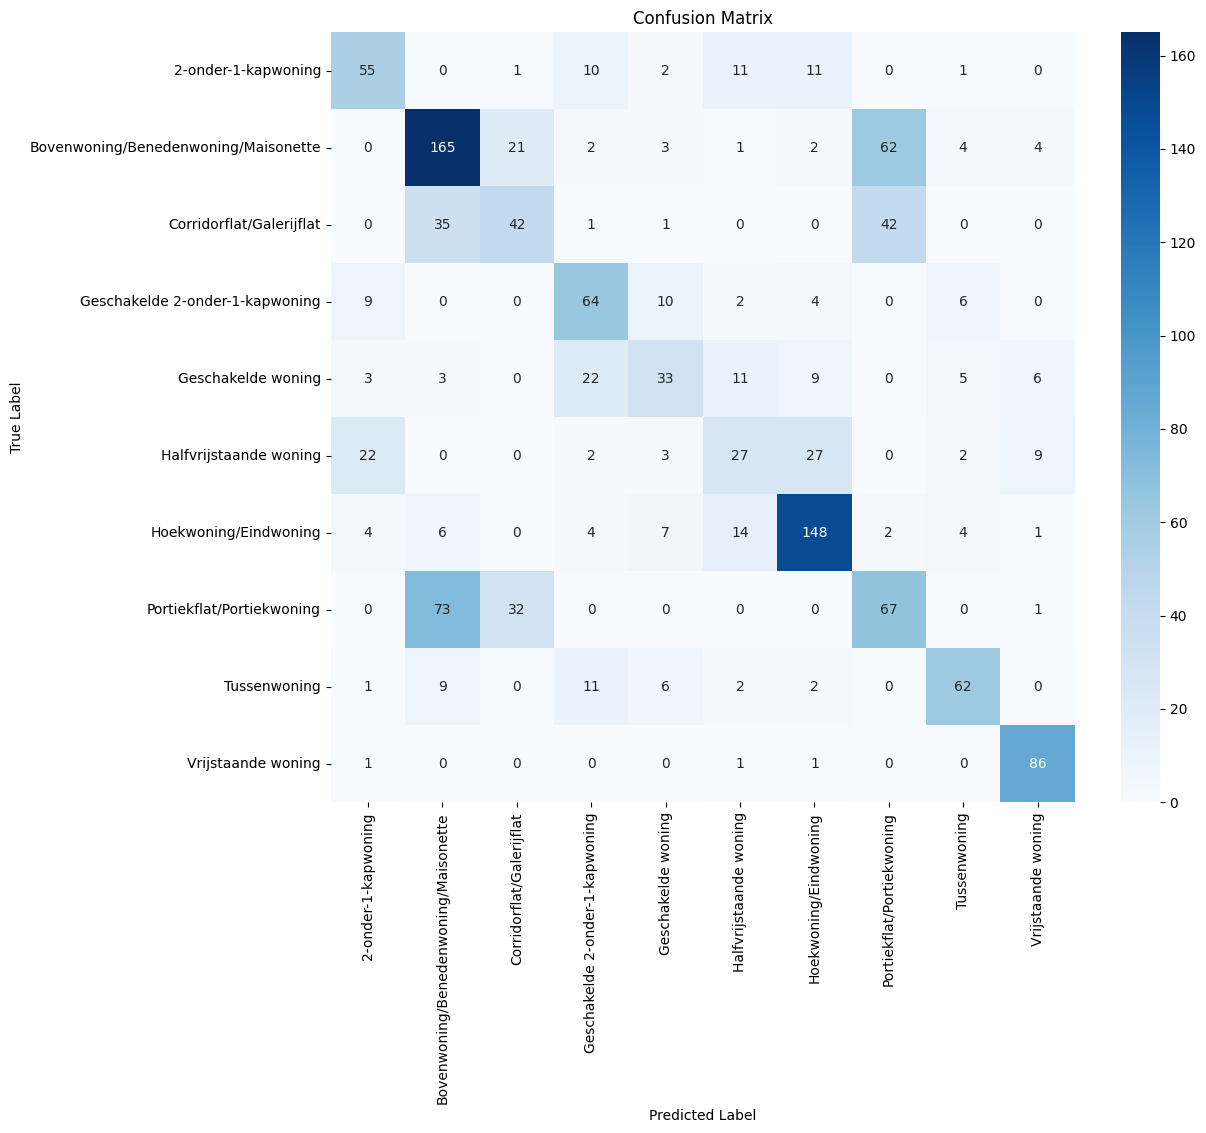


✅ Pipeline finished successfully!


In [28]:
# --- Section 8: Main Pipeline Execution ---
print("🚀 Starting full pipeline execution...")

model_names = ['EarlyFusionModel', 'LateFusionModel', 'EarlyFusionRFC', 'EarlyFusionRFC_MASK']
chosen_model = 'EarlyFusionModel'  # Change this to test different models

# 1. Initialize Model
tabular_input_dim = len(tabular_features)
num_classes = len(label_encoder.classes_)

# Example for Random Forest fusion:
# First, fit the RandomForestTabular model on the training data (outside the model definition)
rfc_tabular = RandomForestTabular(input_dim=tabular_input_dim, num_classes=num_classes)
rfc_tabular.fit(train_df[tabular_features].values, train_df['label'].values)

# Then, create the image model (e.g., ResNet18)
img_model = ImageModel(cnn_output_dim=512, pretrained=True)

# The fusion dimension is image feature dim + num_classes (from RFC output)
fusion_dim = 512 + num_classes

# Now instantiate the fusion model
if chosen_model == 'EarlyFusionModel':
    model = EarlyFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device)
elif chosen_model == 'LateFusionModel':
    model = LateFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes, cnn_output_dim=2048).to(device)
elif chosen_model == 'EarlyFusionRFC':
    model = EarlyFusionRFC(img_model=img_model, rfc_tabular=rfc_tabular, fusion_dim=fusion_dim, num_classes=num_classes).to(device)
else:
    raise ValueError(f"Unknown model type: {chosen_model}")

print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

# 2. Define Loss, Optimizer, and Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Adjusted learning rate and weight decay
NUM_EPOCHS = 5 # You can adjust this
best_val_f1 = 0
BEST_MODEL_PATH = "best_housing_classifier.pth"

print(f"Training for {NUM_EPOCHS} epochs...")

# 3. Run Training and Validation Loop
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
    
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch} Summary:")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        model_path = save_model(model, BEST_MODEL_PATH)
        print(f"🎉 New best model saved with F1 score: {best_val_f1:.4f}")

print("\n✅ Training complete.")

# 4. Evaluate the Best Model on the Test Set
print(f"\n📊 Loading best model from '{model_path}' and evaluating on the test set...")
# Re-initialize a fresh model architecture
if chosen_model == 'EarlyFusionModel':
    final_model = model = EarlyFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes).to(device)
elif chosen_model == 'LateFusionModel':
    final_model = LateFusionModel(tabular_input_dim=tabular_input_dim, num_classes=num_classes, cnn_output_dim=2048).to(device)
elif chosen_model == 'EarlyFusionRFC':
    final_model = EarlyFusionRFC(img_model=img_model, rfc_tabular=rfc_tabular, fusion_dim=fusion_dim, num_classes=num_classes).to(device)

# Load the saved state dict
final_model = load_model(final_model, model_path, device)

class_names = list(label_encoder.classes_)
evaluate_model(final_model, test_loader, device, class_names=class_names)

print("\n✅ Pipeline finished successfully!")

C:\Users\Matth\AppData\Local\Temp\ipykernel_31604\3046468372.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(path, map_loc

Model loaded from models\best_housing_classifier_8.pth and set to evaluation mode.

--- Evaluation Metrics ---
Accuracy: 0.5762
Precision (macro): 0.5689
Recall (macro): 0.5702
F1 Score (macro): 0.5652
Cohen's Kappa: 0.5172
Log Loss: 1.1563

--- Classification Report ---
                                      precision    recall  f1-score   support

                 2-onder-1-kapwoning       0.58      0.60      0.59        91
Bovenwoning/Benedenwoning/Maisonette       0.57      0.62      0.59       264
            Corridorflat/Galerijflat       0.44      0.35      0.39       121
     Geschakelde 2-onder-1-kapwoning       0.55      0.67      0.61        95
                  Geschakelde woning       0.51      0.36      0.42        92
              Halfvrijstaande woning       0.39      0.29      0.34        92
               Hoekwoning/Eindwoning       0.73      0.78      0.75       190
           Portiekflat/Portiekwoning       0.39      0.39      0.39       173
                        T

C:\Users\Matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


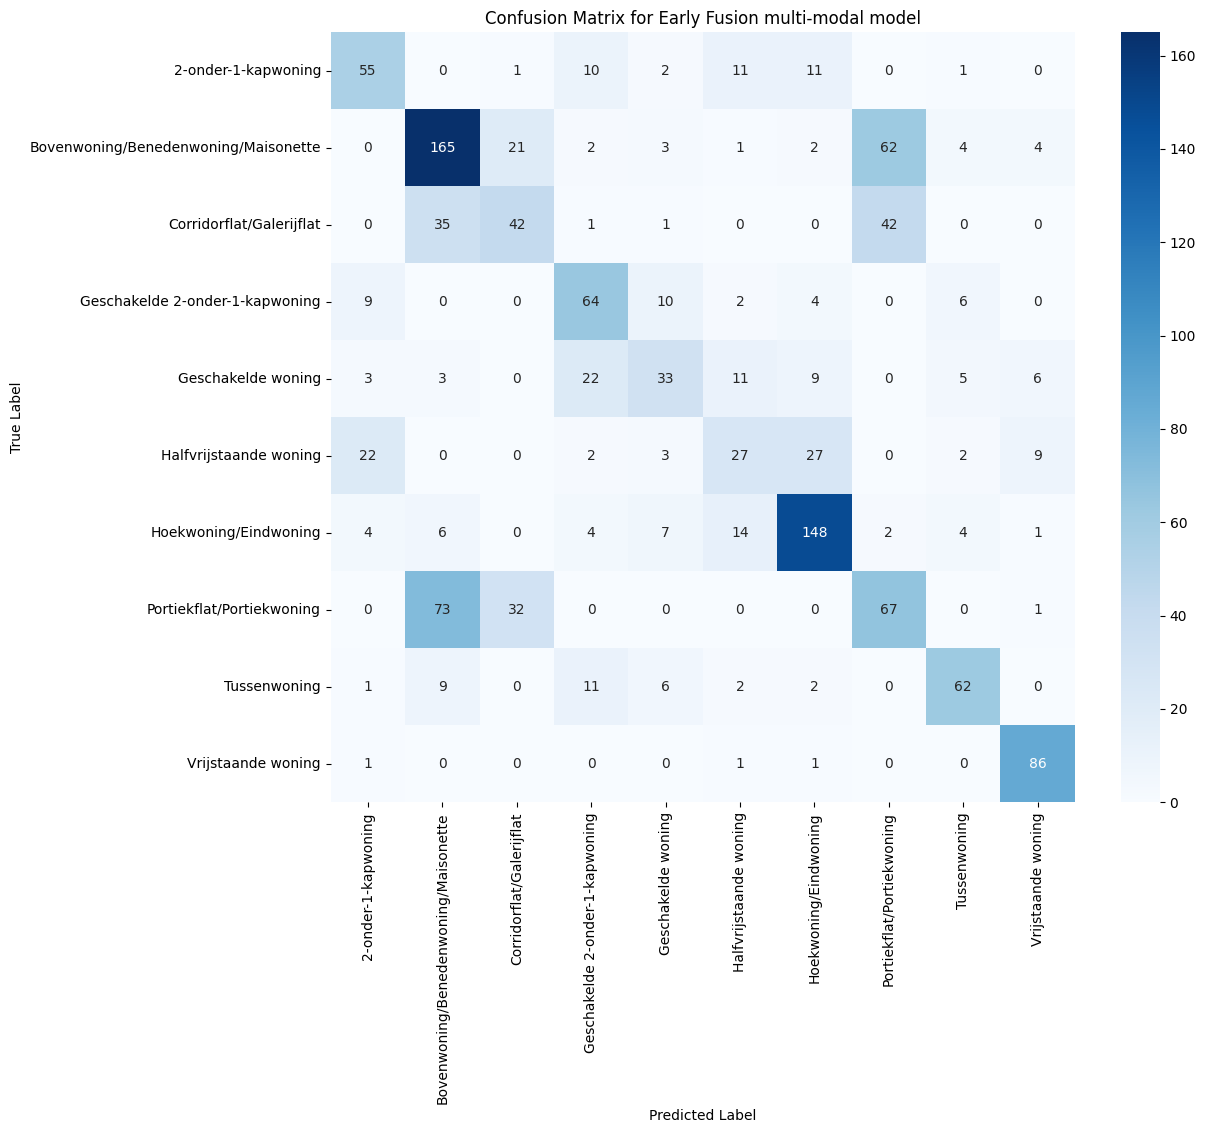

In [30]:
final_model = load_model(final_model, model_path, device)

class_names = list(label_encoder.classes_)
evaluate_model(final_model, test_loader, device, class_names=class_names)